For looking at the results of one call to syn_ahrens_gnldr_mdls

In [1]:
%load_ext autoreload
%autoreload 2 

In [2]:
%matplotlib notebook

In [3]:
import copy
import glob
import pathlib
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch


from ahrens_wbo.annotations import label_subperiods
from ahrens_wbo.annotations import stim_dict
from ahrens_wbo.data_processing import generate_torch_dataset
from ahrens_wbo.data_processing import load_and_preprocess_data
from ahrens_wbo.data_processing import SegmentTable
from janelia_core.ml.datasets import TimeSeriesDataset
from janelia_core.ml.utils import list_torch_devices
from janelia_core.visualization.image_generation import max_project_pts
from janelia_core.visualization.matrix_visualization import cmp_n_mats
from probabilistic_model_synthesis.fa import orthonormalize
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import approximate_elbo
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import evaluate_check_points
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import infer_latents
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import Fitter
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import PriorCollection
from probabilistic_model_synthesis.gaussian_nonlinear_dim_reduction import VICollection
from probabilistic_model_synthesis.gnlr_ahrens_tools import find_period_time_points

## Parameters go here

In [23]:
ps = dir()

# Directory holding results
rs_dir = r'/groups/bishop/bishoplab/projects/probabilistic_model_synthesis/results/real_data/gnldr/same_cond_transfer_analysis/v4/fold_str_base_14_tgt_14/fold_0/subj_8/comb'
rs_file = r'test_results.pt'

# Specify which fit type we look at 
mdl_type = 'ip'

# True if we should use early stoppint to pick the best model
use_early_stopping = True

# Specify the seperate periods we want to measure performance on in the test data
test_periods = ['omr_forward', 'omr_left', 'omr_right']

## See what devices we have available

We will use the first if we have more than one

In [5]:
devices, _ = list_torch_devices()
device = devices[0]

Found 1 GPUs


## Load results

In [6]:
rs = torch.load(pathlib.Path(rs_dir) / rs_file)

In [7]:
fit_ps = rs['ps']
fit_rs = rs['rs']
subject_order = rs['subject_order']
fold = fit_ps['fold']
n_latent_vars = fit_ps['mdl_opts']['n_latent_vars']

## Look at fitting logs 

<IPython.core.display.Javascript object>


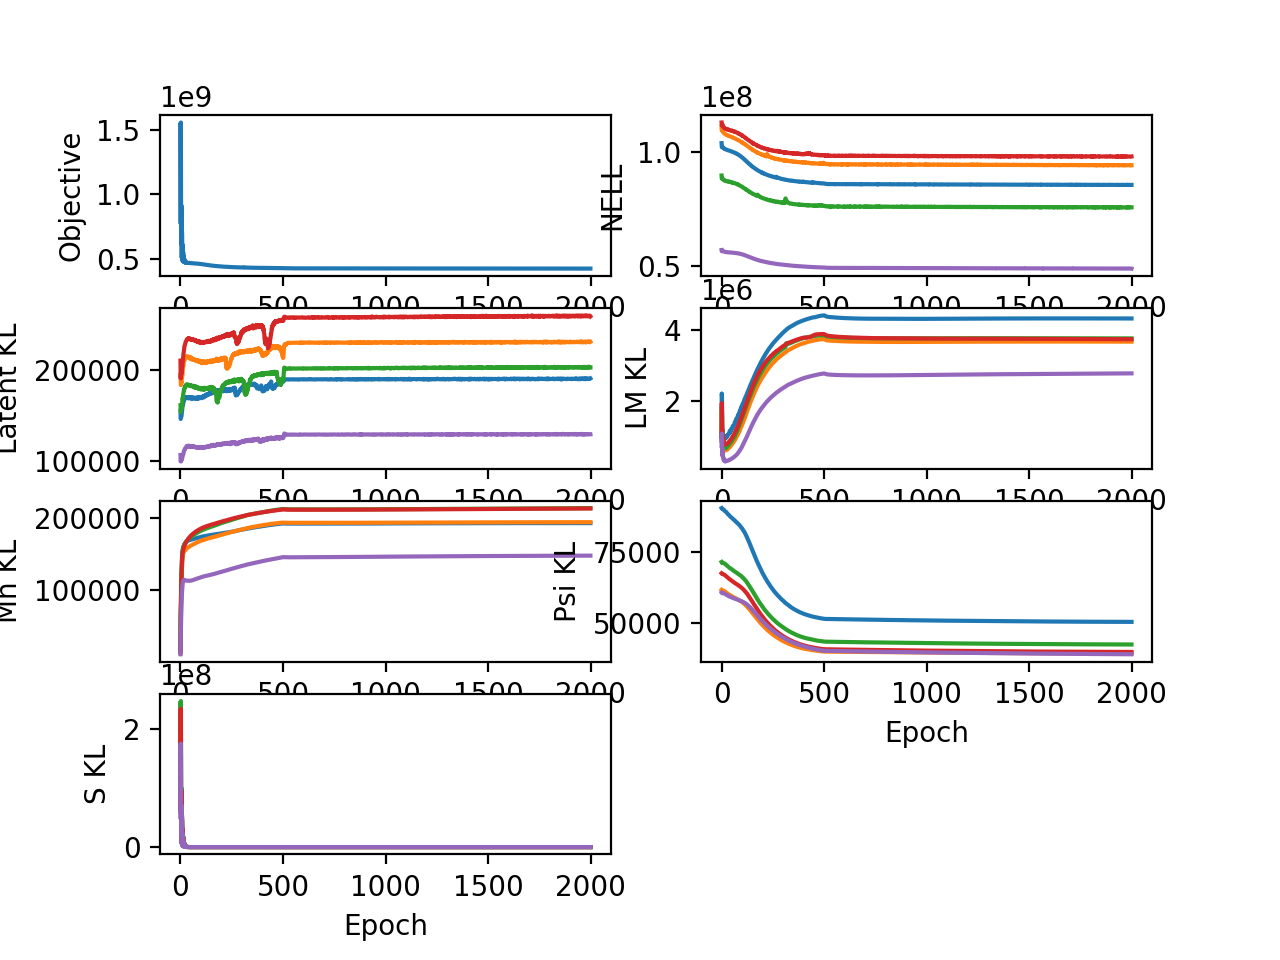

In [8]:
for log in fit_rs[mdl_type]['logs']:
    Fitter.plot_log(log)

## Load the segment tables, fold structures and data 

Load segment tables

In [9]:
segment_table_path = pathlib.Path(fit_ps['segment_table_dir']) / fit_ps['segment_table_file']
with open(segment_table_path, 'rb') as f:
    st_data = pickle.load(f)
    segment_tables = st_data['segment_tables']
segment_tables = {k: SegmentTable.from_dict(v) for k, v in segment_tables.items()}

Load fold structures

In [10]:
fold_str_path = pathlib.Path(fit_ps['fold_str_dir']) / fit_ps['fold_str_file']
with open(fold_str_path, 'rb') as f:
    fold_groups = pickle.load(f)


Load data

In [11]:
subject_data, subject_neuron_locs = load_and_preprocess_data(data_folder=fit_ps['data_dir'], 
                                            subjects=subject_order,
                                            neural_gain=fit_ps['neural_gain'], 
                                            z_ratio=fit_ps['z_ratio'])

Done loading data for subject subject_1.
Done loading data for subject subject_2.
Done loading data for subject subject_5.
Done loading data for subject subject_6.
Done loading data for subject subject_8.


Form the train, validation and test data 

In [12]:
data = dict()
for s_n in subject_order:
    subject_train_slices = segment_tables[s_n].find_all(fold_groups[s_n][fold]['train'])
    train_data_n = generate_torch_dataset(dataset=subject_data[s_n], 
                                          slices=subject_train_slices,
                                          ts_keys=['dff'], inc_time_stamps=True)
    
    train_data_n = (train_data_n.data[0], train_data_n.data[1])

    
    if fold_groups[s_n][fold]['test'] is not None:
        subject_test_slices = segment_tables[s_n].find_all(fold_groups[s_n][fold]['test'])
        test_data_n = generate_torch_dataset(dataset=subject_data[s_n], 
                                             slices=subject_test_slices,
                                             ts_keys=['dff'], inc_time_stamps=True)
    
        test_data_n = (test_data_n.data[0], test_data_n.data[1])
    else:
        test_data_n = None
    
    if fold_groups[s_n][fold]['validation'] is not None:
        subject_validation_slices = segment_tables[s_n].find_all(fold_groups[s_n][fold]['validation'])
        validation_data_n = generate_torch_dataset(dataset=subject_data[s_n], 
                                                   slices=subject_validation_slices,
                                                   ts_keys=['dff'], 
                                                   inc_time_stamps=True)
    
        validation_data_n = (validation_data_n.data[0], validation_data_n.data[1])
    else:
        validation_data_n = None
    
    data[s_n] = {'train': train_data_n, 
                 'test': test_data_n, 
                 'validation': validation_data_n}

## Get labels for all moments in time

In [13]:
labels = {s_n: {'ts': subject_data[s_n].ts_data['stim']['ts'],
                'labels': label_subperiods(subject_data[s_n].ts_data['stim']['vls'][:])} for s_n in subject_order}

## Examine performance across checkpoints

In [14]:
cv_strings = ['train', 'validation', 'test']

In [16]:
n_subjects = len(subject_order)

cp_perf = dict()
cp_logs = dict()
for cv_string in cv_strings:
    cp_epochs, cp_perf[cv_string], cp_files, cp_logs[cv_string] = evaluate_check_points(
                                               cp_folder=pathlib.Path(fit_ps[mdl_type + '_cp_dir']), 
                                               data=[data[s_n][cv_string][0] for s_n in subject_order],
                                               props=[subject_neuron_locs[s_n] for s_n in subject_order],
                                               n_smps=1,
                                               fit_opts=None,
                                               elbo_opts=None,
                                               device=device)

Done with check point: 1 of 21.
Done with check point: 2 of 21.
Done with check point: 3 of 21.
Done with check point: 4 of 21.
Done with check point: 5 of 21.
Done with check point: 6 of 21.
Done with check point: 7 of 21.
Done with check point: 8 of 21.
Done with check point: 9 of 21.
Done with check point: 10 of 21.
Done with check point: 11 of 21.
Done with check point: 12 of 21.
Done with check point: 13 of 21.
Done with check point: 14 of 21.
Done with check point: 15 of 21.
Done with check point: 16 of 21.
Done with check point: 17 of 21.
Done with check point: 18 of 21.
Done with check point: 19 of 21.
Done with check point: 20 of 21.
Done with check point: 21 of 21.
Done with check point: 1 of 21.
Done with check point: 2 of 21.
Done with check point: 3 of 21.
Done with check point: 4 of 21.
Done with check point: 5 of 21.
Done with check point: 6 of 21.
Done with check point: 7 of 21.
Done with check point: 8 of 21.
Done with check point: 9 of 21.
Done with check point: 10 of

## View a log for the latent estimation for on of the checkpoints

In [17]:
cp_log = cp_logs['test'][10][0]

<IPython.core.display.Javascript object>


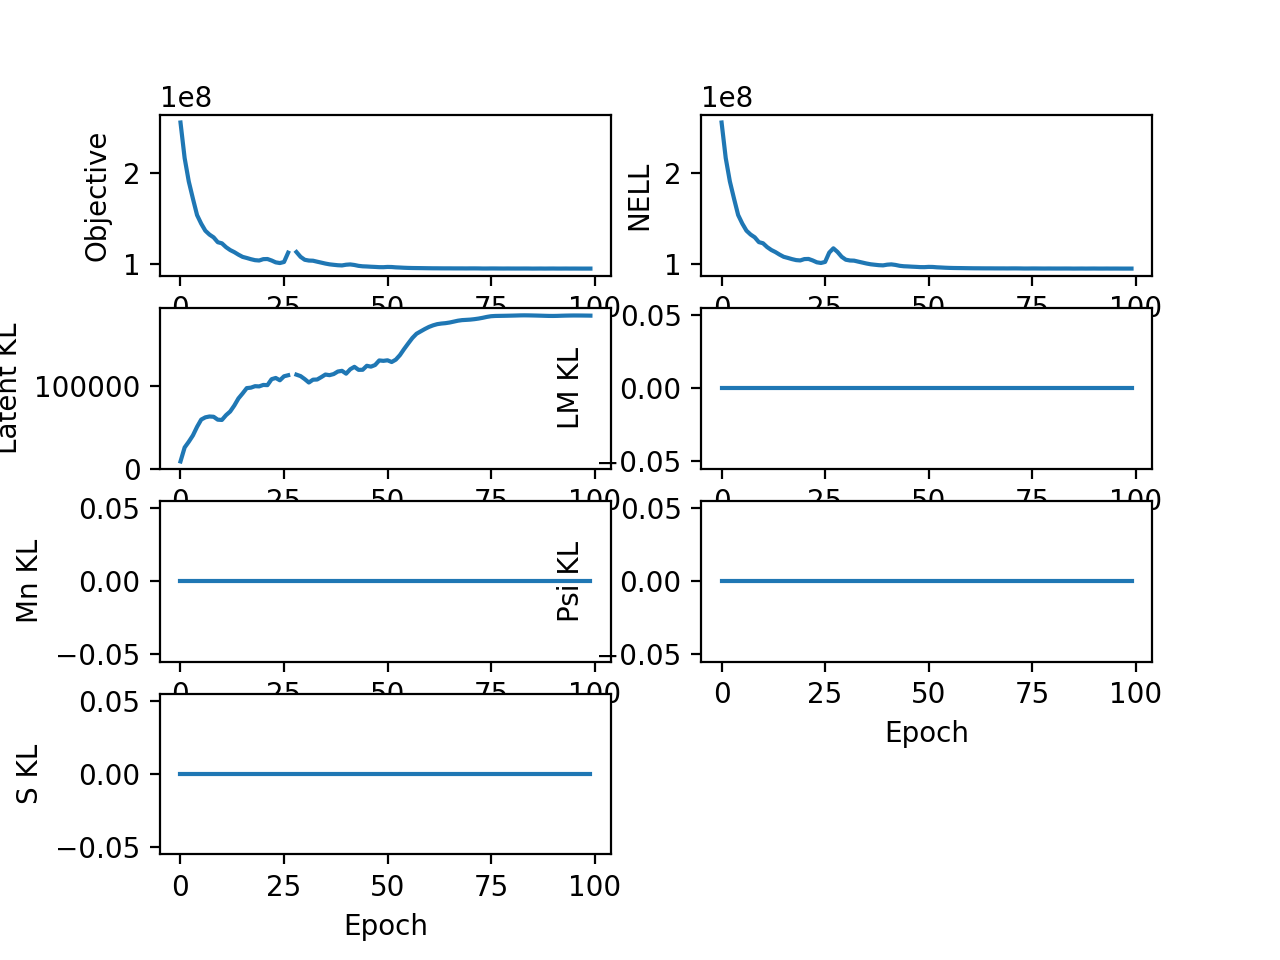

In [18]:
Fitter.plot_log(cp_log)

## View performance across check points

In [19]:
cp_type = 'validation'

In [40]:
cp_avg = np.nanmean(cp_perf[cp_type], axis=1)

<IPython.core.display.Javascript object>


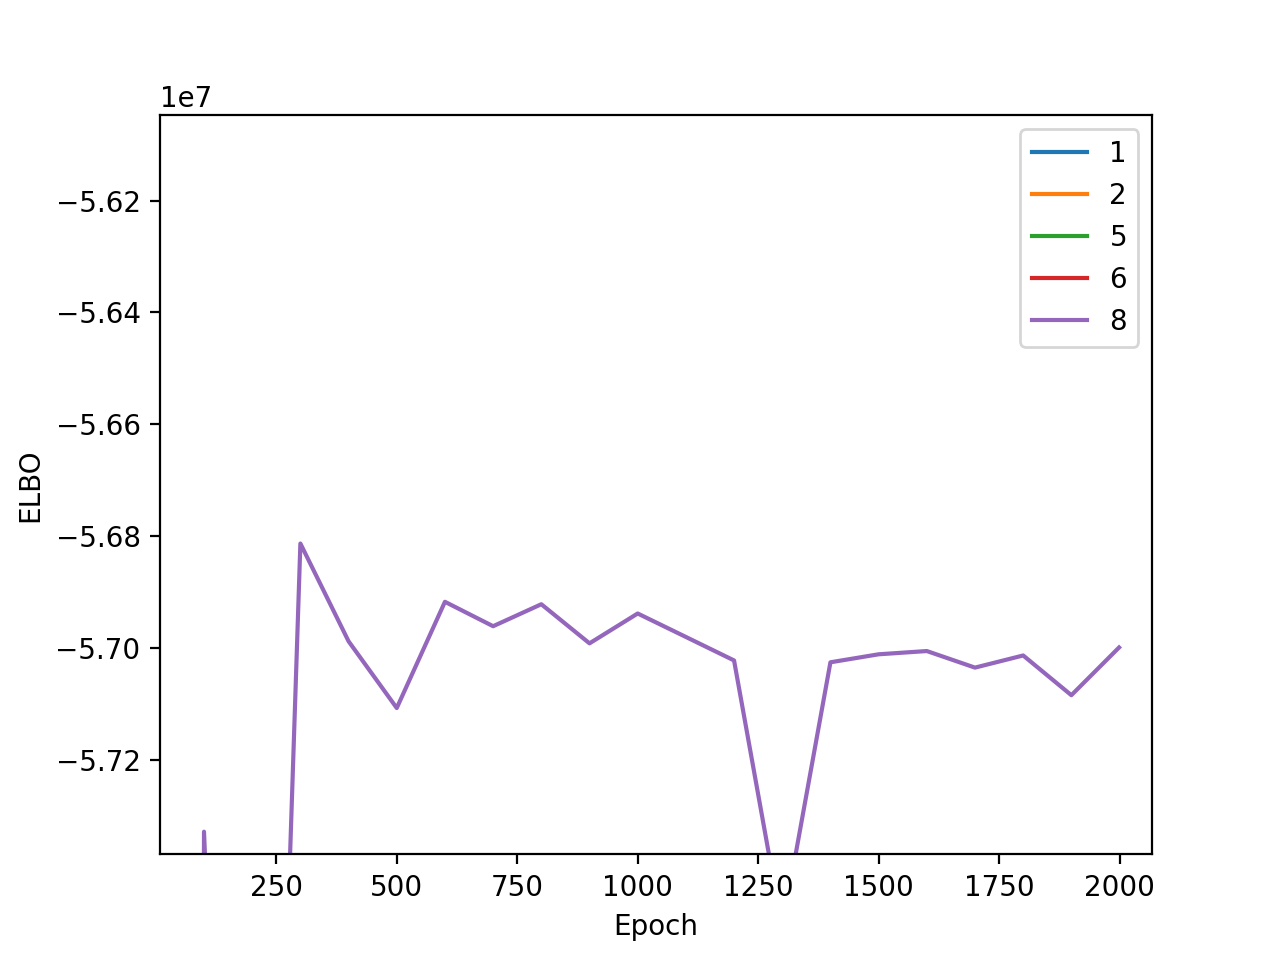

Text(0, 0.5, 'ELBO')

In [21]:
plt.figure()
plt.plot(cp_epochs, cp_perf[cp_type])
plt.legend(subject_order)
plt.plot(cp_epochs, cp_avg, 'k--')
plt.xlabel('Epoch')
plt.ylabel('ELBO')

## Pick best check point based on early stopping

In [42]:
if use_early_stopping:
    best_cp_ind = np.argmax(cp_avg)
    best_cp= torch.load(cp_files[best_cp_ind])
    eval_vi_colls = [VICollection.from_checkpoint(coll) for coll in best_cp['vi_collections']]
    eval_priors = PriorCollection.from_checkpoint(best_cp['priors'])
    print('Best CP Epoch: ' + str(cp_epochs[best_cp_ind]))
else:
    eval_vi_colls = fit_rs[mdl_type]['vi_collections']
    eval_priors = fit_rs[mdl_type]['priors']

Best CP Epoch: 300.0


Repopulate properties in the vi collection

In [43]:
for s_i, s_n in enumerate(subject_order):
    eval_vi_colls[s_i].props = subject_neuron_locs[s_n]

## Infer latents for the picked model

In [44]:
latents = dict()
for s_i, s_n in enumerate(subject_order):
    sub_latents = dict()
    for cv_string in cv_strings:
        if data[s_n][cv_string] is not None:
            latents_posts, latent_log = infer_latents(n_latent_vars=n_latent_vars,
                                                  vi_collection=eval_vi_colls[s_i],
                                                  data=data[s_n][cv_string][0],
                                                  fit_opts={'n_epochs': 100, 'init_lr':.1, 'update_int':None, 
                                                            'milestones': [50], 'n_batches': 2}, 
                                                  device=device, 
                                                  distribute_data=True)
        
        
            sub_latents[cv_string] = {'posts': latents_posts, 'log': latent_log}
            print('Done infering latents for subject ' + str(s_n) + ', ' + cv_string + '.')
        else:
            sub_latents[cv_string] = None
    latents[s_n] = sub_latents

Done infering latents for subject 1, train.
Done infering latents for subject 1, validation.
Done infering latents for subject 1, test.
Done infering latents for subject 2, train.
Done infering latents for subject 2, validation.
Done infering latents for subject 2, test.
Done infering latents for subject 5, train.
Done infering latents for subject 5, validation.
Done infering latents for subject 5, test.
Done infering latents for subject 6, train.
Done infering latents for subject 6, validation.
Done infering latents for subject 6, test.
Done infering latents for subject 8, train.
Done infering latents for subject 8, validation.
Done infering latents for subject 8, test.


## View a log for latent inference

In [45]:
latent_view_log = latents[8]['validation']['log']

<IPython.core.display.Javascript object>


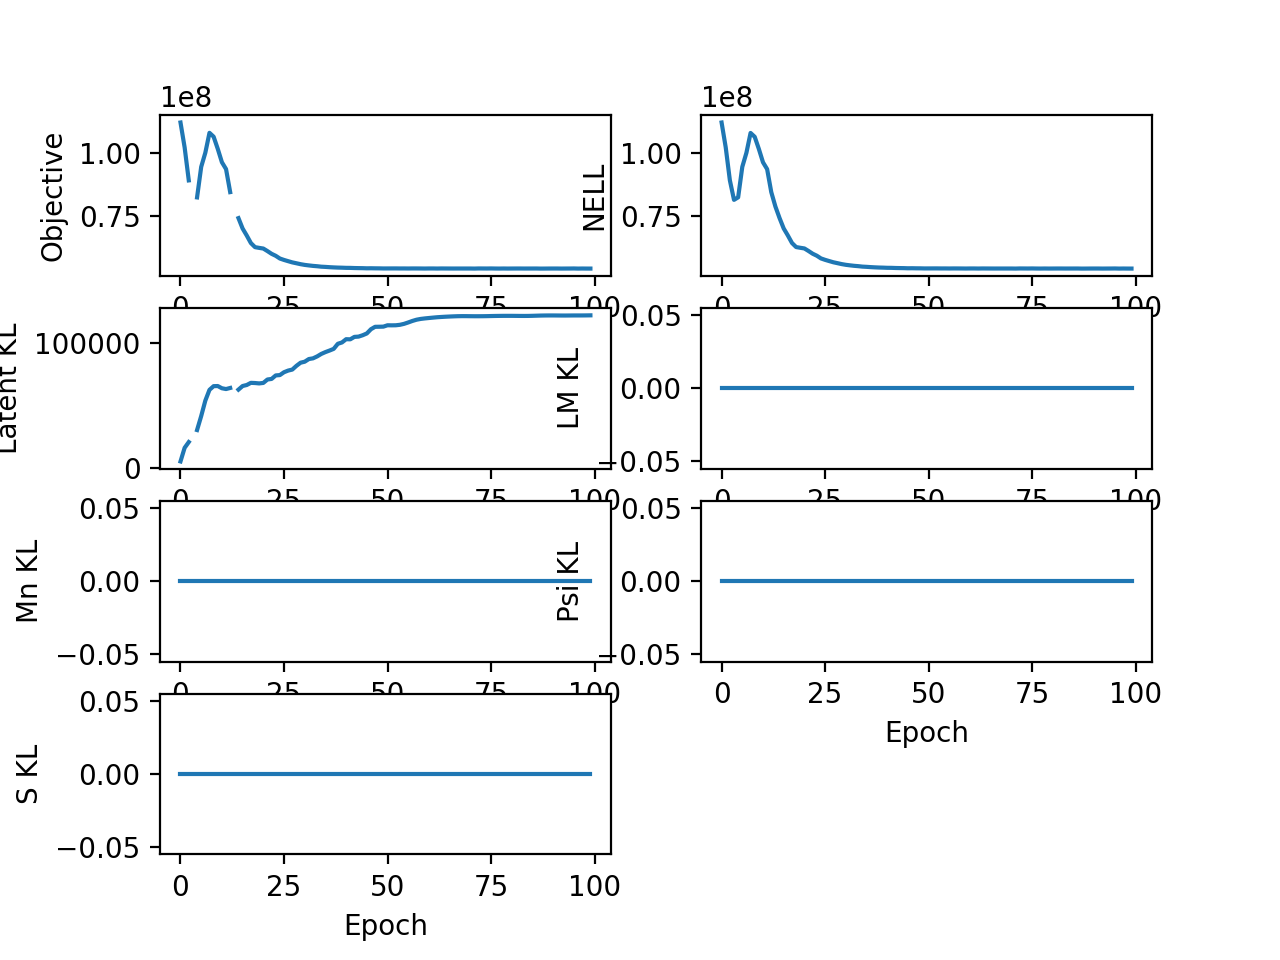

In [46]:
Fitter.plot_log(latent_view_log)

## Evaluate ELBO on training, validation and testing data for evaluation models

In [47]:
elbo_vls = dict()
for s_i, s_n in enumerate(subject_order):
    eval_coll_i = copy.deepcopy(eval_vi_colls[s_i])
    subj_elbo = dict()
    for cv_string in cv_strings:
        if latents[s_n][cv_string] is not None:
            eval_coll_i.data = data[s_n][cv_string][0]
            eval_coll_i.posteriors.latent_post = latents[s_n][cv_string]['posts']
            with torch.no_grad():
                subj_elbo[cv_string] = approximate_elbo(coll=eval_coll_i, priors=eval_priors, n_smps=10)
            print('Done estimagint ELBO for subject ' + str(s_n) + ', ' + cv_string + '.')
        else:
            subj_elbo[cv_string] = None
    elbo_vls[s_n] = subj_elbo

Done estimagint ELBO for subject 1, train.
Done estimagint ELBO for subject 1, validation.
Done estimagint ELBO for subject 1, test.
Done estimagint ELBO for subject 2, train.
Done estimagint ELBO for subject 2, validation.
Done estimagint ELBO for subject 2, test.
Done estimagint ELBO for subject 5, train.
Done estimagint ELBO for subject 5, validation.
Done estimagint ELBO for subject 5, test.
Done estimagint ELBO for subject 6, train.
Done estimagint ELBO for subject 6, validation.
Done estimagint ELBO for subject 6, test.
Done estimagint ELBO for subject 8, train.
Done estimagint ELBO for subject 8, validation.
Done estimagint ELBO for subject 8, test.


In [48]:
for cv_string in cv_strings:
    print('***** ' + cv_string + ' *****')
    for s_n in subject_order:
        if elbo_vls[s_n][cv_string] is not None:
            print('Subject ' + str(s_n) + ':' + '{:.2E}'.format(elbo_vls[s_n][cv_string]['elbo'].item()))
        else:
            print('None')

***** train *****
Subject 1:-9.25E+07
Subject 2:-1.00E+08
Subject 5:-8.15E+07
Subject 6:-1.04E+08
Subject 8:-5.31E+07
***** validation *****
Subject 1:-9.97E+07
Subject 2:-1.05E+08
Subject 5:-8.76E+07
Subject 6:-1.10E+08
Subject 8:-5.68E+07
***** test *****
Subject 1:-9.94E+07
Subject 2:-1.07E+08
Subject 5:-8.75E+07
Subject 6:-1.10E+08
Subject 8:-5.70E+07


## Evaluate ELBO on the different periods in the testing data 

In [ ]:
period_elbo_vls = dict()
for s_i, s_n in enumerate(subject_order):
    period_elbo_vls[s_n] = dict()
    if data[s_n]['test'] is not None:
        test_ts = data[s_n]['test'][1].numpy()
        for test_period in test_periods:
            test_inds = find_period_time_points(cand_ts=test_ts, 
                                                period=test_period,
                                                shock=False,
                                                labels=labels[s_n])
            if len(test_inds) > 0:
                eval_coll_i = copy.deepcopy(eval_vi_colls[s_i])
                eval_coll_i.data = data[s_n]['test'][0][test_inds,:]
                latent_post = copy.deepcopy(latents[s_n]['test']['posts'])
                latent_post.n = len(test_inds)
                latent_post.mns.data = latent_post.mns.data[test_inds,:]
                eval_coll_i.posteriors.latent_post = latent_post
                with torch.no_grad():
                    period_elbo_vls[s_n][test_period] = approximate_elbo(coll=eval_coll_i, priors=eval_priors, n_smps=10)
    else:
        period_elbo_vls[s_n] = None
                

In [ ]:
for s_n in subject_order:
    print('Period ELBO Values on Test Data for Subject ' + str(s_n))
    if period_elbo_vls[s_n] is not None:
        for test_period in period_elbo_vls[s_n].keys():
            print(test_period + ': ELBO ' + str(period_elbo_vls[s_n][test_period]['elbo'].item()) + 
                  ', ELL: ' + str(period_elbo_vls[s_n][test_period]['ell'].item()))
    else:
        print('None')

## Orthonormalize latents

In [49]:
# TODO: Still need to account for scales here
lm_conc = np.concatenate([eval_vi_colls[s_i].posteriors.lm_post(subject_neuron_locs[s_n]).detach().numpy()
           for s_i, s_n in enumerate(subject_order)], axis=0)

In [50]:
for s_n in subject_order:
    for cv_string in cv_strings:
        if latents[s_n][cv_string] is not None:
            mns = latents[s_n][cv_string]['posts'].mns.detach().numpy()
            _, mns_o = orthonormalize(lm=lm_conc, latents=mns)
            latents[s_n][cv_string]['mns'] = mns
            latents[s_n][cv_string]['mns_o'] = mns_o

## Visualize latents

In [51]:
plot_cv_string = 'test'

<IPython.core.display.Javascript object>


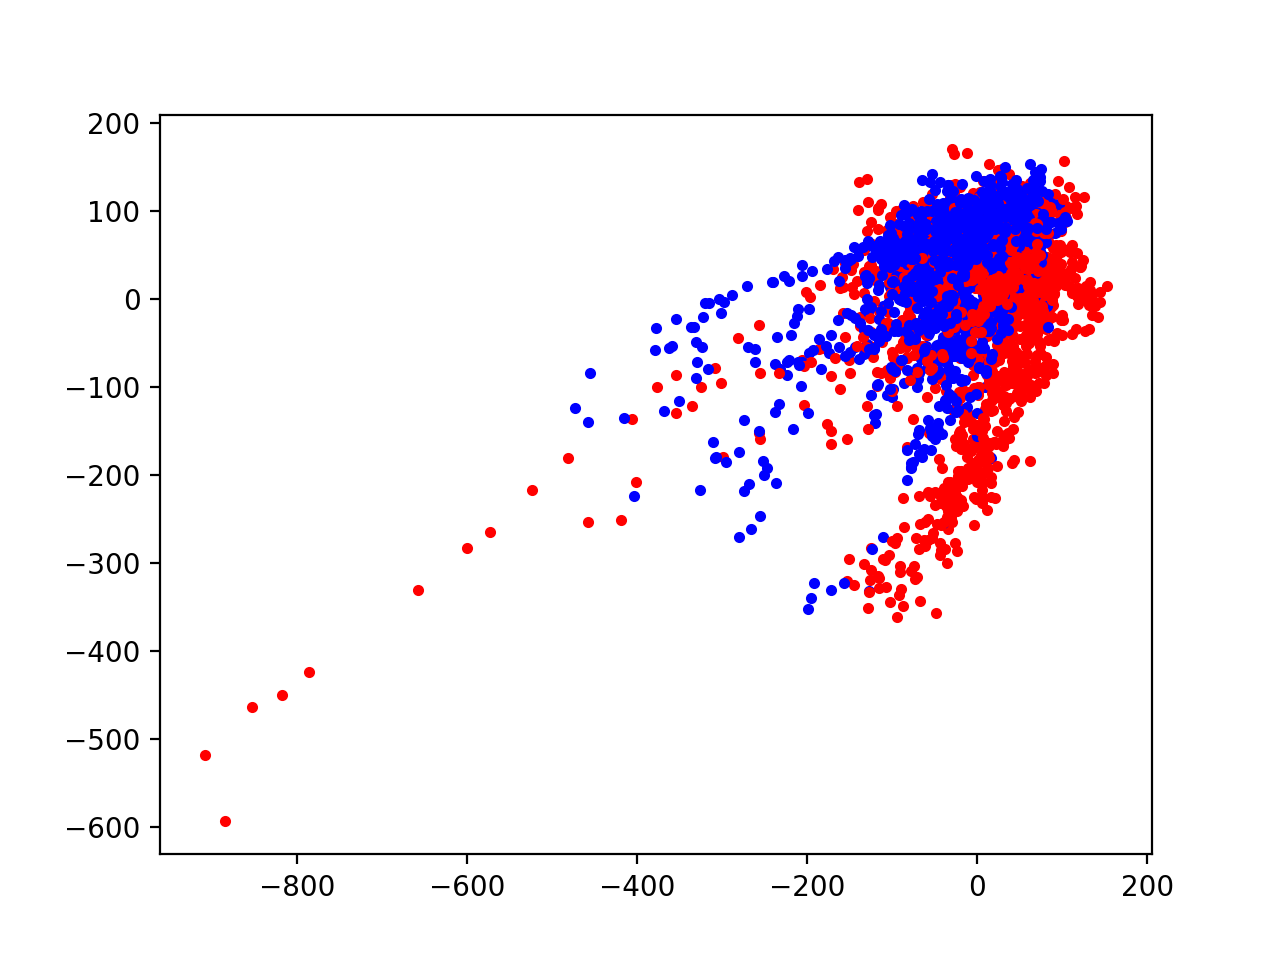

In [52]:
plt.figure()
for s_n in subject_order:
    if latents[s_n][plot_cv_string] is not None:
    
        subject_ts = subject_data[s_n].ts_data['stim']['ts']
        subject_stim = subject_data[s_n].ts_data['stim']['vls'][:]
    
        left_ts = subject_ts[subject_stim == stim_dict['phototaxis_left']]
        right_ts = subject_ts[subject_stim == stim_dict['phototaxis_right']]
    
        cv_ts = data[s_n][plot_cv_string][1]
        _, left_inds, _ = np.intersect1d(cv_ts, left_ts, return_indices=True)
        _, right_inds, _ = np.intersect1d(cv_ts, right_ts, return_indices=True)
    
    
        plt.plot(latents[s_n][plot_cv_string]['mns_o'][left_inds, 0],
                 latents[s_n][plot_cv_string]['mns_o'][left_inds, 1], 'r.')
    
        plt.plot(latents[s_n][plot_cv_string]['mns_o'][right_inds, 0],
                 latents[s_n][plot_cv_string]['mns_o'][right_inds, 1], 'b.')

## Visualize loading matrices across space

In [53]:
lm_conc_o,_ = orthonormalize(lm=lm_conc)
lm_o = dict()
cur_start = 0
for s_n in subject_order:
    n_vars_n = data[s_n]['train'][0].shape[1]
    lm_o[s_n] = lm_conc_o[cur_start:cur_start+n_vars_n]
    cur_start += n_vars_n

In [72]:
vis_comp = 49

In [73]:
mode_imgs = dict()
for s_n in subject_order:
    neuron_locs_n = subject_neuron_locs[s_n]
    
    lm_n = lm_o[s_n]
    
    mode_imgs[s_n], _ = max_project_pts(dot_positions=neuron_locs_n.numpy()[:,[0,1]].astype('float'),
                                        dot_vls=lm_n[:,vis_comp], 
                                        box_position=np.asarray([[0, 0], [990, 610]]), 
                                        n_divisions=np.asarray([990, 610]), 
                                        dot_dim_width=np.asarray([5,5]))
    
 

<IPython.core.display.Javascript object>


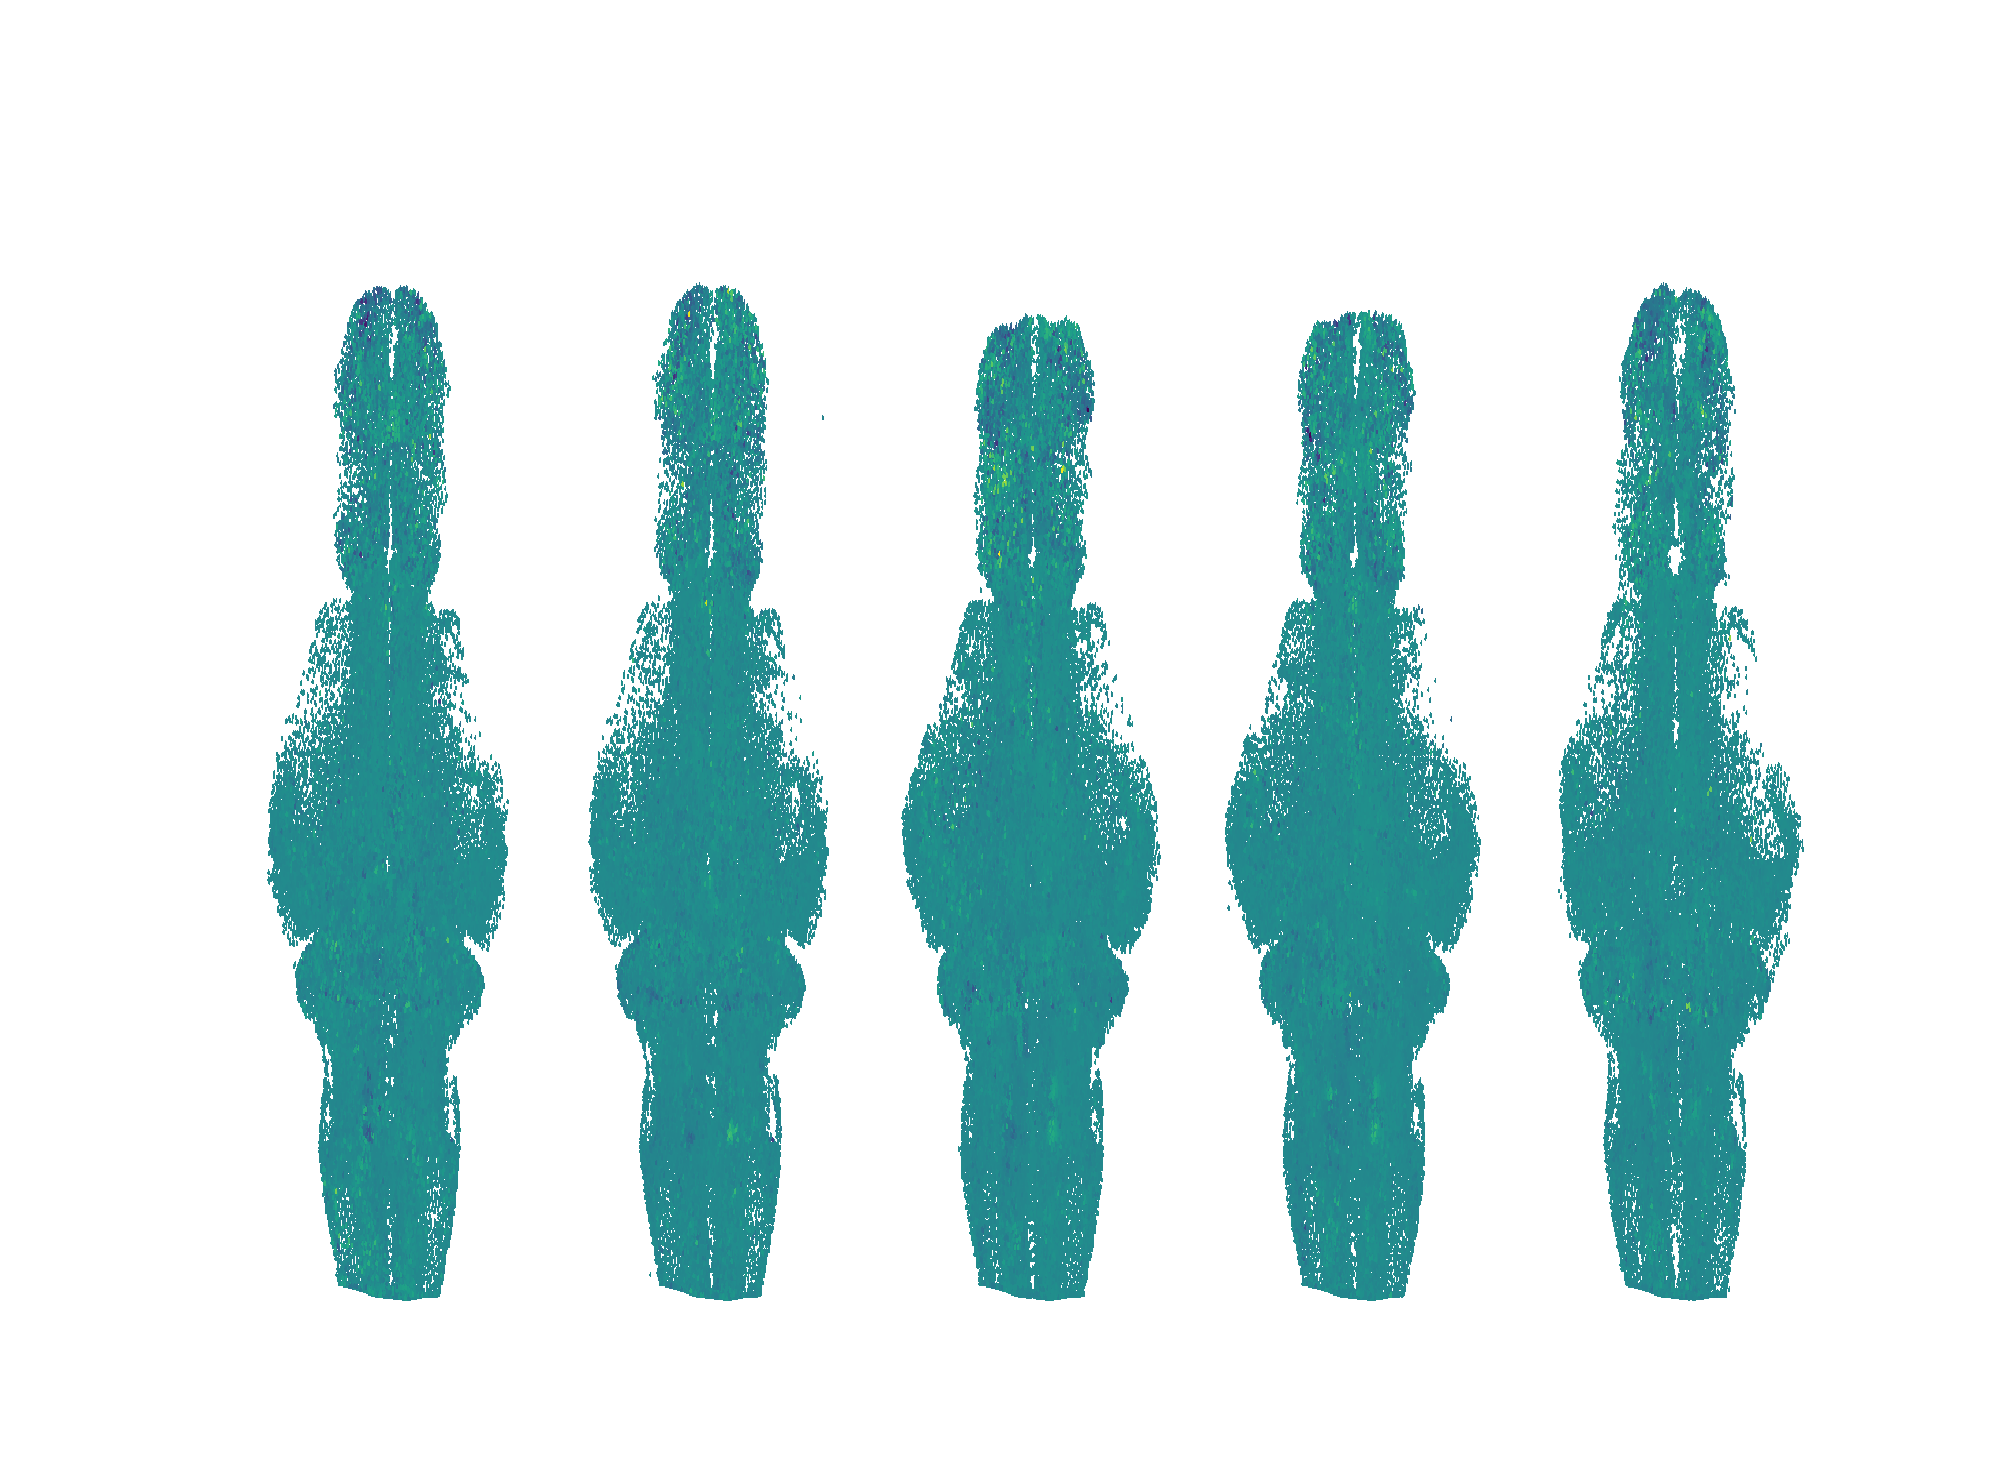

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>]

In [74]:
plt.figure()
cmp_n_mats([mode_imgs[k] for k in mode_imgs.keys()])  

## Debug code goes here

In [82]:
eval_vi_colls = fit_rs[mdl_type]['vi_collections']
eval_priors = fit_rs[mdl_type]['priors']

In [142]:
vis_imgs = dict()

for s_i, s_n in enumerate(subject_order):
    neuron_locs_n = subject_neuron_locs[s_n]
    
    std_vls = eval_vi_colls[s_i].posteriors.lm_post.dists[0].std_f(neuron_locs_n).detach().numpy()
    #std_vls = eval_priors.s_prior.std_f(neuron_locs_n).detach().numpy()
    
    #std_vls = eval_vi_colls[s_i].posteriors.psi_post.mode(neuron_locs_n).detach().numpy()
    #std_vls = eval_priors.psi_prior.mode(neuron_locs_n).detach().numpy()
    
    
    vis_imgs[s_n], _ = max_project_pts(dot_positions=neuron_locs_n.numpy()[:,[0,1]].astype('float'),
                                        dot_vls=std_vls, 
                                        box_position=np.asarray([[0, 0], [990, 610]]), 
                                        n_divisions=np.asarray([990, 610]), 
                                        dot_dim_width=np.asarray([5,5]))
    

<IPython.core.display.Javascript object>


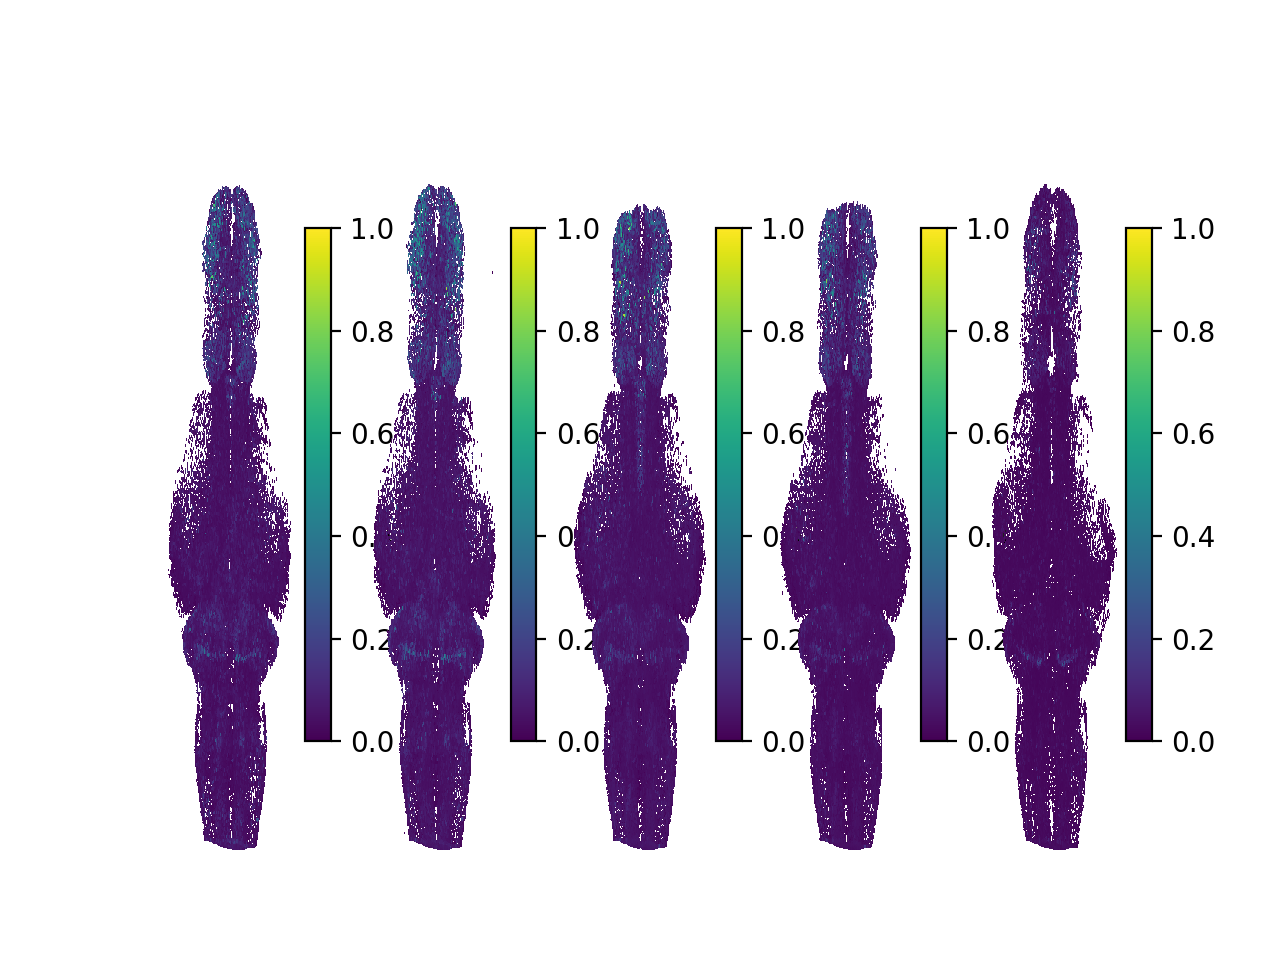

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>]

In [144]:
plt.figure()
cmp_n_mats([vis_imgs[k] for k in mode_imgs.keys()], show_colorbars=True, clim=[0, 1.0])  

In [76]:
post_dist = eval_vi_colls[1].posteriors.latent_post

In [77]:
#post_dist = latents[1]['validation']['posts']

In [78]:
cov_m = post_dist.cov().detach().numpy()

<IPython.core.display.Javascript object>


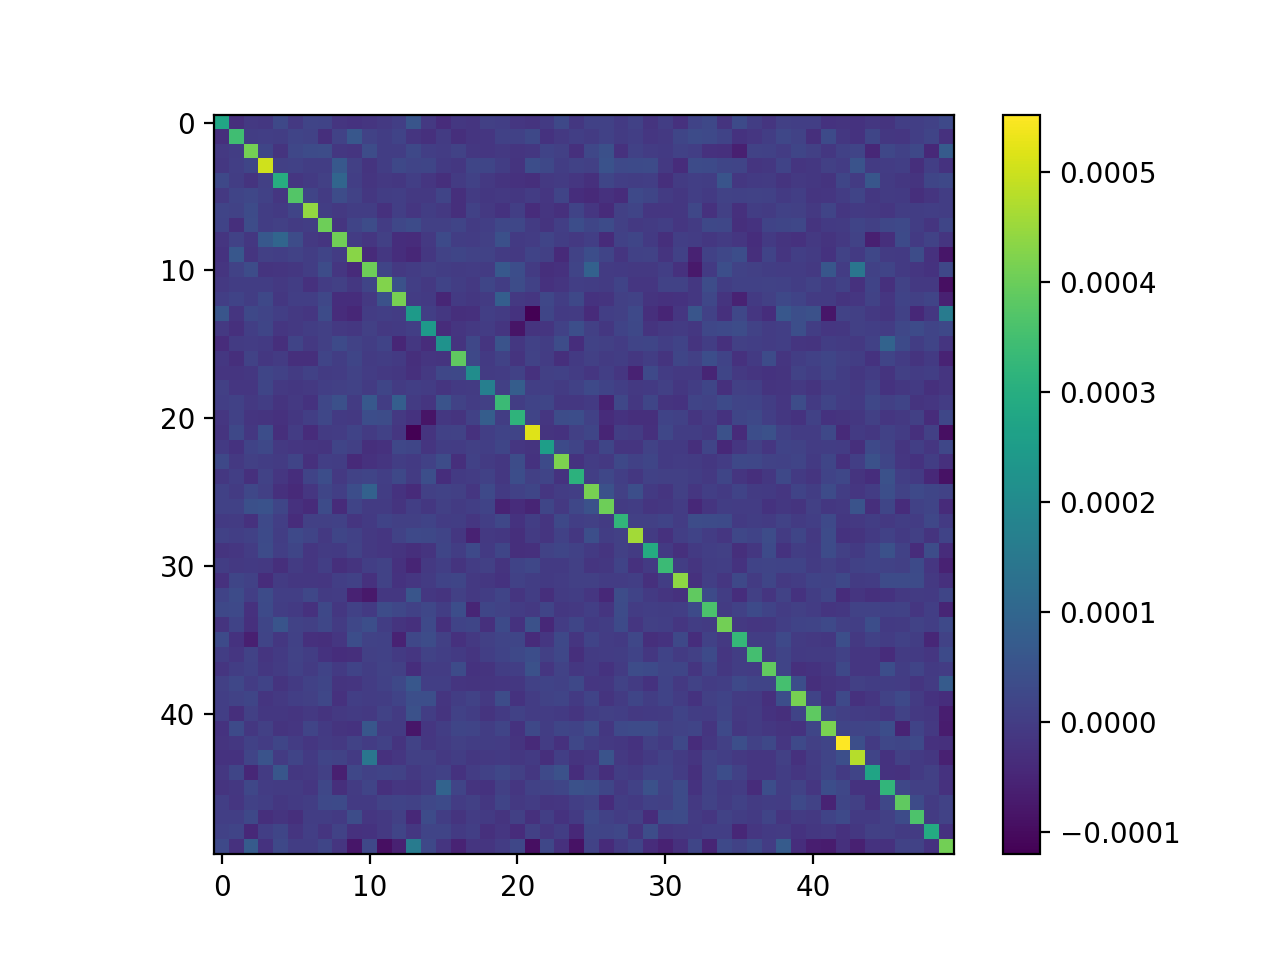

In [79]:
plt.figure()
plt.imshow(cov_m)
plt.colorbar()

In [80]:
mns = post_dist.mns.detach().numpy()

<IPython.core.display.Javascript object>


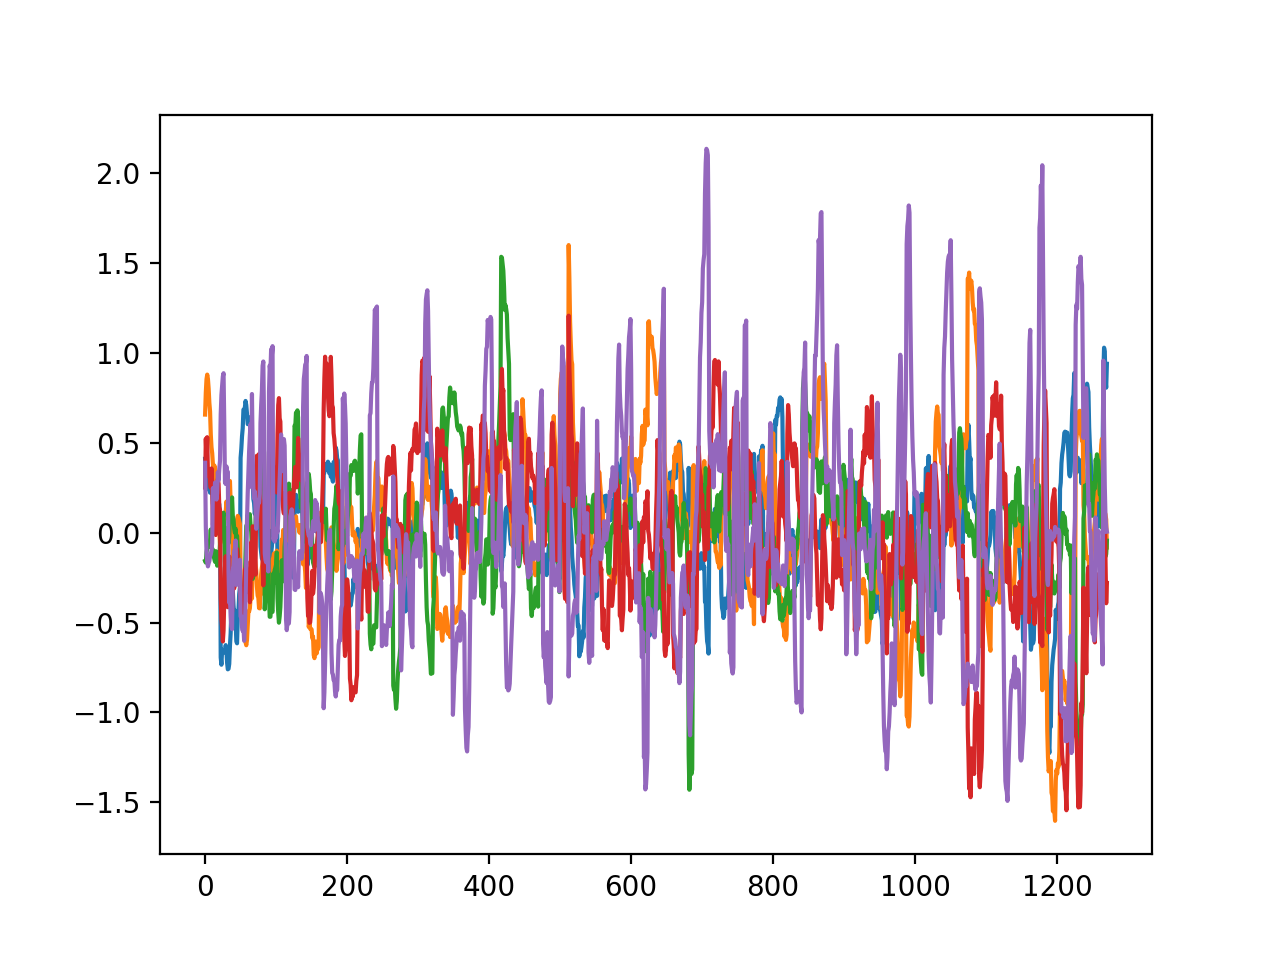

In [81]:
plt.figure()
for d_i in range(5):
    plt.plot(mns[:,d_i])